In [45]:
#général
import pandas as pd
import numpy as np
import time

#traitement texte
import re

#visualisation
import matplotlib.pyplot as plt

In [46]:
t1 = time.time()
#données d'entrée
df=pd.read_fwf(r"C:\Users\John\Desktop\Formation\TH-NL-P1-decoupage_des_roles_d_une_piece_de_theatre\Le_Malade_imaginaire.txt",header=None,sep=" ")
lnom = ['argan', 'béline', 'angélique', 'cléante', 'béralde', 'louison', 'toinette']
lnom_comp = ['monsieur','thomas']
lstage = ['ACTE', 'Scène', 'prologue', 'INTERMÈDE']

# Exploration

In [47]:
# extrait du df
df[300:350]

,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,52
300,"Et, si de t’agréer je n’emporte le prix,",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
301,J’aurai du moins l’honneur de l’avoir entrepri...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
302,* * *,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
303,ACTE PREMIER.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
304,* * *,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
305,Scène I.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306,"argan, assis, une table devant lui, comptant a...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307,"Trois et deux font cinq, et cinq font dix, et ...","e, c’est que ses parties sont toujours fort ci...","s entrailles de monsieur, trente sols. » Oui ;...","if, composé avec catholicon double, rhubarbe, ...","ur, trente sols. » Avec votre",permissi,"n, dix sols. « Plus, dudit jour, le soir, un j...",aire dormir mon,"ieur, t",ente-cinq sols. »,...,", comme de","sus, trente sols. » Monsie","r Fleurant, dix sols","« Plus, du vingt-septi","me, une bon",e médecin,", composée pour hâter d’aller et chasser deh","rs les mauvaises humeurs de monsieur,","rois livres. » Bon, vingt et trente sols ; je sui",NaN
308,Scène II.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
309,"ARGAN, TOINETTE.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 1-Cleaning

In [48]:
# Punctuation removal function
def remove_punct(text):
    """
        Remove the punctuation
    """
    return re.sub(r'[]!"$%&\'()*+,./:;=#@?[\\^_`{|}~-]+', "", text)


In [49]:
df

,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,52
0,Le Malade imaginaire,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Molière,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Exporté de Wikisource le 15 mars 2023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"LE MALADE IMAGINAIRE,",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,COMÉDIE-BALLET EN TROIS ACTES.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3203,* * *,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3204,↑ http://fr.wikisource.org,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3205,↑ http://creativecommons.org/licenses/by-sa/3....,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3206,↑ http://www.gnu.org/copyleft/fdl.html,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
# On enlève la ponctuation et on tokenize
#from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
df = df.applymap(lambda x : tokenizer.tokenize(x) if type(x) == str else x)

In [51]:
# On enlève la ponctuation et on tokenize
#from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
for c in range(0,df.shape[1]):
    for r in range(0,len(df)):
        if type(df.iloc[r,c]) == str :
            tokenizer = RegexpTokenizer(r'\w+')
            df.iloc[r,c] = tokenizer.tokenize(df.iloc[r,c])
            #df.iloc[r,c] = word_tokenize(df.iloc[r,c])

In [ ]:
# Rassembler les lignes dans une colonne "cleaned"
from functools import reduce
col = []
for i in range(0, len(df)):
    df.col.append(reduce(lambda x,y : x+y if (type(x) == list and type(y) == list) else x, df[i:i+1].values.tolist()[0]))
df["cleaned"] = col

## 2-Extraction des données

In [7]:
# Création d'un tableau réduit aux lignes étapes et personnages. Les lignes sont identifiées par leur index
data = [['Index', 'Acte', 'Scène', 'Personnage', 'Nb de mots']]

In [8]:
# On itère le tableau data
# pour chaque ligne
for r in range(0, len(df)):
    # si elle contient un mot de lnom ou lstage
    for nom in lnom + lstage + lnom_comp:
        try:
            if nom in df["cleaned"][r][0:1]:
                # on appende la ligne
                data.append([r,df["cleaned"][r][0:2],0,0,0])
        except:
            continue

In [9]:
# stockage des noms au type texte au lieu de liste
for i in range(0,len(data)):
    for n in lnom:
        if n in data[i][1]:
            data[i][1] = n
    for n in lnom_comp:
        if n in data[i][1]:
            data[i][1] = ' '.join(data[i][1])

In [10]:
# petite vérification sur les actes et intermèdes
ext = [sous_liste for sous_liste in data if any(isinstance(item, list) and ('INTERMÈDE' in item or 'ACTE' in item) for item in sous_liste if isinstance(item, (str, list)))]
ext

[[303, ['ACTE', 'PREMIER'], 0, 0, 0],
 [1277, ['ACTE', 'SECOND'], 0, 0, 0],
 [2016, ['ACTE', 'TROISIÈME'], 0, 0, 0]]

In [11]:
# on cherche l'index du df de la première ligne qui contient 'ACTE' dans data
start_index = data.index([303, ['ACTE', 'PREMIER'], 0, 0, 0])

In [12]:
# on redessine data en data_ à partir de cette ligne
data_ = data.copy()
data_ = data_[0:1]+data_[6:]

In [13]:
# on met les noms à leur place
for r in range(1, len(data_)):
    if isinstance(data_[r][1],str):
        
        data_[r][3]=data_[r][1]
        data_[r][1]=0

In [14]:
# CORRECTIF : On remplace les monsieur de par monsieur de bonnefoi
for i in range(0,len(data_)):
    if data_[i][3] == 'monsieur de':
        data_[i][3] = 'monsieur de bonnefoi'    

In [15]:
# on fait la même chose pour ACTE
for r in range(1, len(data_)):
    try:
        if 'ACTE' in data_[r][1]:
            new = data_[r][1][0] + " " + data_[r][1][1]
            data_[r][1] = new
    except:
        continue

In [16]:
# on fait la même chose pour Scène
for r in range(1, len(data_)):
    try:
        if 'Scène' in data_[r][1]:
            new = data_[r][1][0] + " " + data_[r][1][1]
            data_[r][2] = new
            data_[r][1] = 0
    except:
        continue

In [17]:
# Maintenant dans les lignes où on a le nom des personnages on va compter le nb de mot dans la tirade
# On stock le n° de la ligne considérée
list_l = [data_[i][0] for i in range(1,len(data_)) if data_[i][3]!=0]

In [18]:
# On stocke dans des variable l'index des lignes de départ (exlus) et de fin de la tirade (exclus)
for i in range(0,len(list_l)):
    db = list_l[i]
    try :
        fi = list_l[i+1]
    except :
        fi = db + 2
    # On stocke dans une variable le nombre de mots entre db exclus jusqu'à fi exclus
    nb = reduce(lambda x,y : x+y, [len(df.loc[df.index ==r,"cleaned"].values.tolist()[0]) for r in range(db+1,fi)])
    # Et on met ce nombre dans la dernière cellule de la ligne correspondant à db dans data_
    index = None
    for i, row in enumerate(data_):
        if row[0] == db:
            index = i
            break
    data_[index][-1] = nb

In [19]:
#on va colorer les lignes caractéristiques détectées et voir ce que ça donne sur un doc excel

# Indices des lignes à colorer
indices_to_color = [data[r][0] for r in range(1, len(data))]

# Création de la fonction de mise en forme pour colorer les lignes spécifiques
def highlight_row(row):
    if row.name in indices_to_color:
        return ['background-color: yellow'] * len(row)
    else:
        return [''] * len(row)

# Application de la fonction de mise en forme au DataFrame
styled_df = df.style.apply(highlight_row, axis=1)

# Affichage du DataFrame stylisé
styled_df.to_excel("df_color.xlsx")

In [20]:
# Maintenant on mais les acte et les scènes dans les lignes au même niveau que les personnages dans data_
# Si la ligne contient Acte on copie cette données dans les cellules du dessous jusqu'à rencontrer une 
# nouvelle cellule différente de 0
for r in range(1,len(data_)):
    if data_[r][1] != 0:
        i = r+1
        try:
            while data_[i][1] == 0:
                data_[i][1] = data_[r][1]
                i = i+1
        except:
            break

In [21]:
# Même chose avec les scène
for r in range(1,len(data_)):
    if data_[r][2] != 0:
        i = r+1
        try:
            while data_[i][2] == 0:
                data_[i][2] = data_[r][2]
                i = i+1
        except:
            break

In [22]:
# Et pour terminer on supprime toutes les lignes qui n'ont pas de personnage
data_f = [row for row in data_ if row[3]!=0]

In [23]:
# On convertif en df
df_t = pd.DataFrame(data_f[1:], columns = data_f[0])

In [24]:
series = df_t.groupby(['Acte','Personnage'])['Nb de mots'].sum()

## Visualisation

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Index(['angélique', 'argan', 'béline', 'monsieur de bonnefoi', 'toinette',
       'angélique', 'argan', 'béline', 'béralde', 'cléante', 'louison',
       'monsieur diafoirus', 'thomas diafoirus', 'toinette', 'angélique',
       'argan', 'béline', 'béralde', 'cléante', 'monsieur fleurant',
       'monsieur purgon', 'toinette'],
      dtype='object', name='Personnage')
Index(['ACTE PREMIER', 'ACTE PREMIER', 'ACTE PREMIER', 'ACTE PREMIER',
       'ACTE PREMIER', 'ACTE SECOND', 'ACTE SECOND', 'ACTE SECOND',
       'ACTE SECOND', 'ACTE SECOND', 'ACTE SECOND', 'ACTE SECOND',
       'ACTE SECOND', 'ACTE SECOND', 'ACTE TROISIÈME', 'ACTE TROISIÈME',
       'ACTE TROISIÈME', 'ACTE TROISIÈME', 'ACTE TROISIÈME', 'ACTE TROISIÈME',
       'ACTE TROISIÈME', 'ACTE TROISIÈME'],
      dtype='object', name='Acte')


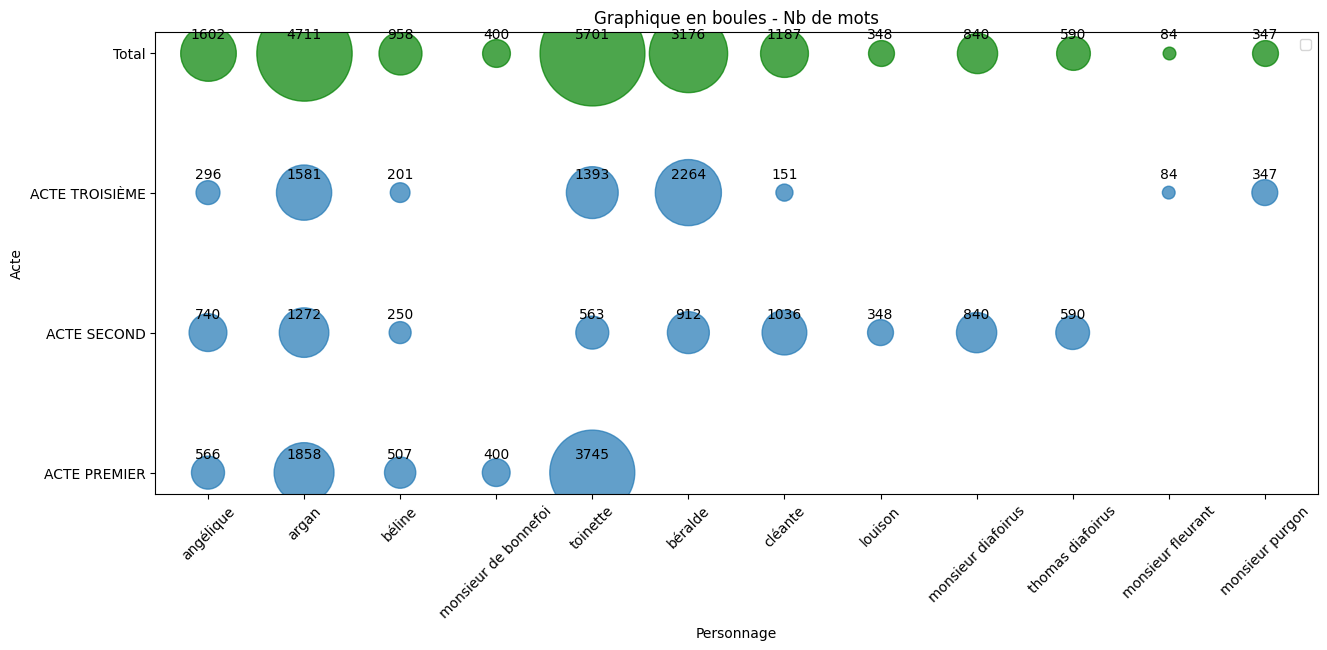

temps de traitement =  18.93289566040039


In [25]:
# Calculer le total par personnage
total_par_personnage = series.groupby(level='Personnage').sum()

# Création du graphique en boules initial
fig, ax = plt.subplots(figsize=(15, 6))
ax.scatter(series.index.get_level_values('Personnage'), series.index.get_level_values('Acte'),
           s=series.values, alpha=0.7)

# Ajouter des boules pour le total par personnage
for personnage, total in total_par_personnage.items():
    ax.scatter(personnage, "Total", s=total, c='green', alpha=0.7)#, label=f'Total {personnage}')

# Configuration des axes et du titre
ax.set_xlabel('Personnage')
ax.set_ylabel('Acte')
ax.set_title('Graphique en boules - Nb de mots')
plt.xticks(rotation=45)

# Vérification
print(series.index.get_level_values('Personnage')) 
print(series.index.get_level_values('Acte'))

# Afficher la valeur dans la boule pour le graphique initial
for x, y, val in zip(series.index.get_level_values('Personnage'), series.index.get_level_values('Acte'), series.values):
    ax.annotate(str(val), (x, y), textcoords="offset points", xytext=(0, 10), ha='center')

# Afficher la valeur dans la boule pour le total par personnage
for personnage, total in total_par_personnage.items():
    ax.annotate(str(total), (personnage, "Total"), textcoords="offset points", xytext=(0, 10), ha='center')

# Légende pour les boules du total par personnage
ax.legend()

# Affichage du graphique
plt.show()
print("temps de traitement = ", time.time()-t1)